In [1]:
!pip install fairlearn
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
           'hours_per_week', 'native_country', 'income']
df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)

df.dropna(inplace=True)

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.81


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
sensitive_feature = X_test['sex']

mf = MetricFrame(
    metrics={"selection_rate": selection_rate},
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = sensitive_feature
)

print("Selection rate by group (sex):")
print(mf.by_group)

dpd = demographic_parity_difference(y_test, y_pred, sensitive_features = sensitive_feature)
print(f"\nDemographic Parity Difference: {dpd:.3f}")

Selection rate by group (sex):
     selection_rate
sex                
0          0.049413
1          0.169652

Demographic Parity Difference: 0.120


In [6]:
sensitive_feature_train = X_train['sex']
sensitive_feature_test = X_test['sex']

estimator = LogisticRegression(solver = 'liblinear')

mitigator = ExponentiatedGradient(
    estimator,
    constraints = DemographicParity(),
    sample_weight_name = "sample_weight"
)

mitigator.fit(X_train, y_train, sensitive_features = sensitive_feature_train)

y_pred_mitigated = mitigator.predict(X_test)

mf_mitigated = MetricFrame(
    metrics = {"selection_rate": selection_rate},
    y_true = y_test,
    y_pred = y_pred_mitigated,
    sensitive_features = sensitive_feature_test
)

print("Mitigated selection rate by sex")
print(mf_mitigated.by_group)

dpd_mitigated = demographic_parity_difference(
    y_test, y_pred_mitigated, sensitive_features = sensitive_feature_test)
print(f"\nDemographic Parity Difference (mitigated): {dpd_mitigated:.3f}")

Mitigated selection rate by sex
     selection_rate
sex                
0          0.066399
1          0.091257

Demographic Parity Difference (mitigated): 0.025


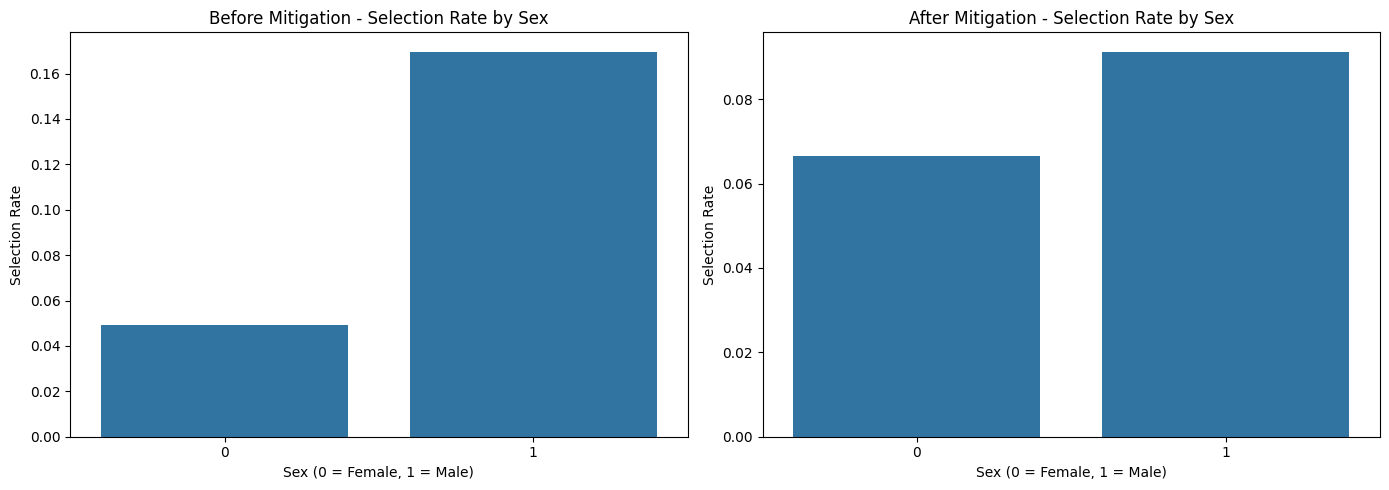

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

sns.barplot(x = mf.by_group.index, y = mf.by_group["selection_rate"], ax = ax[0])
ax[0].set_title("Before Mitigation - Selection Rate by Sex")
ax[0].set_ylabel("Selection Rate")
ax[0].set_xlabel("Sex (0 = Female, 1 = Male)")

sns.barplot(x = mf_mitigated.by_group.index, y = mf_mitigated.by_group["selection_rate"], ax = ax[1])
ax[1].set_title("After Mitigation - Selection Rate by Sex")
ax[1].set_ylabel("Selection Rate")
ax[1].set_xlabel("Sex (0 = Female, 1 = Male)")

plt.tight_layout()
plt.show()

In [12]:
acc_before = accuracy_score(y_test, y_pred)
acc_after = accuracy_score(y_test, y_pred_mitigated)

print(f"Accuracy before mitigation: {acc_before:.3f}")
print(f"Accuracy after mitigation: {acc_after:.3f}")

Accuracy before mitigation: 0.813
Accuracy after mitigation: 0.798
